In [18]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import py_tps as tps
from PIL import Image

from torch import nn
from torchvision import datasets, models, transforms
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from skimage.segmentation import disk_level_set

import time
import pickle

from models import U_Net

In [19]:
class LandmarksDataset():
    def __init__(self): # инициация программы и установление основных значений
        self.drive_dir = '../data/interin' # <- Путь до папки где лежит папка на которых будим учится
        self.image_dir = 'Ac_Fom_2022_WM_scale' # <- Название папки с исходными фото и файлом *.TPS
        self.tps_file_name = 'Ac_Fom2022WM_FL_scale.TPS' # <- Название файла *.TPS
        self.tps_file = tps.TPSFile.read_file(os.path.join(self.drive_dir, self.image_dir, self.tps_file_name))
        self.transform = False # <- Нужно ли трасформировать исходные изображения, если нужно параметры для трансформации в поле self.params
        self.disk_radius = 2
        self.params = {'rotation_range':[40], 'zoom_range':[0.7,1.3], 'height_shift_range':[-0.05, 0.05], 'width_shift_range':[-0.05, 0.05], 'contrast_range':1}

    def __getitem__(self, index): # получение изображения и коррдинат точек к нему, случайное изменение изображения, перевод изображения в формат torch

        # Загрузка фото и его перевод в массив numpy, определение размера в пиксилях
        image = Image.open(os.path.join(self.drive_dir, self.image_dir, self.tps_file.images[index].image))
        image_array = np.array(image)
        image_shape = image_array.shape
    
        # Загрузка ландмарок и их зеркальное отображение по вертикали
        landmarks = self.tps_file.images[index].landmarks.points
        landmarks_flip = np.zeros(landmarks.shape)
        landmarks_flip[:,0] = landmarks[:,0]
        landmarks_flip[:,1] = image_shape[0] - landmarks[:,1]
        params = self.params

        # Масштабирование исходного изображения и его нормировка
        img_shape = image.size
        image = TF.resize(image, (224,224))
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5],[0.5])

        # Масштабирование ландмарок и их нормировка
        landmarks_flip = torch.tensor(landmarks_flip)/torch.tensor([img_shape[0],img_shape[1]])

        # Создание масок
        c, shape, n = image.shape
        landmarks_masks = []
        for landmark in landmarks_flip:
            mask = disk_level_set(image_shape=(shape,shape), center=(landmark[1]*224,landmark[0]*224), radius=self.disk_radius)
            landmarks_masks.append(mask)
        landmarks_masks = np.array(landmarks_masks).astype(np.float32)
        landmarks_masks = torch.from_numpy(landmarks_masks)
        
        landmarks_flip = landmarks_flip.clone().detach() - 0.5

        return image, landmarks_flip, landmarks_masks

    def __len__(self):
        return len(self.tps_file.images)

In [20]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    for t, m ,s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
    return tensor

19 torch.Size([224, 224]) <function amax at 0x7b93f4795bc0>


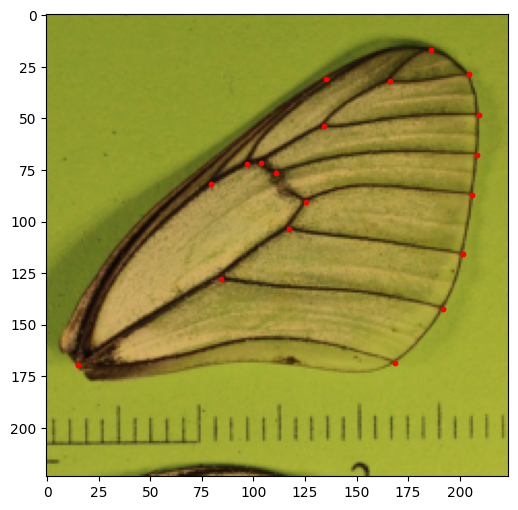

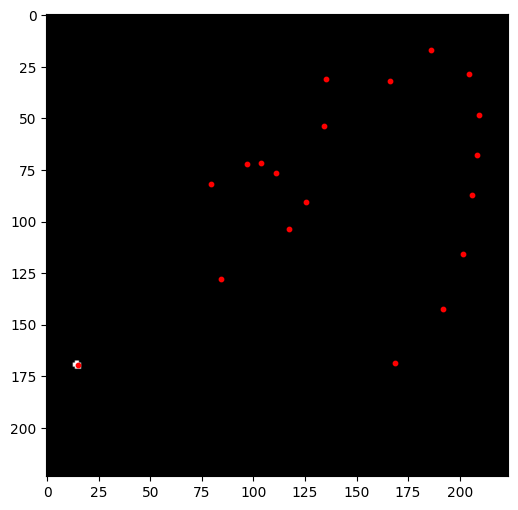

In [21]:
dataset = LandmarksDataset()

image, landmarks, masks = dataset[-1]
print(len(masks), masks[0].shape, np.amax)
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image)

landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
image = image.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,6))
plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')
plt.figure(figsize=(10,6))
plt.imshow(masks[0], cmap="gray")
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')

In [22]:
len_valid_test_set = int(0.1*len(dataset)) # 80% тренировочная выборка, 10% валидационная выборка, 10% тестовая выборка

len_train_set = len(dataset) - len_valid_test_set*2

print("Длина тренировочной выборки {}".format(len_train_set))
print("Длина валидационной выборки {}".format(len_valid_test_set))
print("Длина тестовой выборки {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(38))

# Смешивание и объединение наборов данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)

Длина тренировочной выборки 225
Длина валидационной выборки 28
Длина тестовой выборки 28


In [26]:
network = U_Net(3, 19)
network.cpu()

U_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [ ]:
# network.load_state_dict(torch.load('../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth', map_location=torch.device('cpu')))

In [28]:
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))

    sys.stdout.flush()

In [30]:
calc_loss = nn.CrossEntropyLoss()

torch.autograd.set_detect_anomaly(True)

loss_list = {'train': [], 'val':[], 'time': []}

initial_lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=initial_lr) # try SGD
#opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

MAX_STEP = int(1e10)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, MAX_STEP, eta_min=1e-5, verbose = True)

loss_min = np.inf
num_epochs = 1

start_time = time.time()
for epoch in range(0,num_epochs):
    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    for step in range(1, len(train_loader)+1):

        images, landmarks, masks = next(iter(train_loader))

        images = images.cpu()
#         landmarks = landmarks.view(landmarks.size(0),-1).cpu()
        masks = masks.cpu()
        predictions = network(images)

        optimizer.zero_grad()

        loss_train_step = calc_loss(predictions, masks)

        loss_train_step.backward()


        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')


    network.eval()
    with torch.no_grad():

        for step in range(1,len(valid_loader)+1):


            images, landmarks, masks = next(iter(valid_loader))

            images = images.cpu()
#             landmarks = landmarks.view(landmarks.size(0),-1).cuda()
            masks = masks.cpu()
            predictions = network(images)

            loss_valid_step = calc_loss(predictions, masks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Эпоха: {}  Train Loss: {:.8f}  Valid Loss: {:.8f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    #loss_list['time'].append(time.time()-start_time)
    f = open("../data/interin/Ac_Fom_2022_WM_scale/model_unet_NoTransF_trainingdata_0.pkl","wb")
    pickle.dump(loss_list,f)
    f.close()
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth')
        print('Минимальная ошибка валидации Valid loss: {:.8f} на эпохе {}'.format(loss_min, epoch, num_epochs))
        print('Модель сохранена\n')

print('Обучение завершено')
print('Всего затрачено времени: {} c.'.format(time.time()-start_time))
loss_list['time'].append(time.time()-start_time)

Valid Steps: 2/2  Loss: 0.03552965 1 
--------------------------------------------------
Эпоха: 0  Train Loss: 0.00488911  Valid Loss: 0.03552965
--------------------------------------------------
Минимальная ошибка валидации Valid loss: 0.03552965 на эпохе 0
Модель сохранена

Обучение завершено
Всего затрачено времени: 309.0969250202179 c.


In [46]:
def get_predicted_landmarks(predicted_masks):
    landmarks = []
    for mask in predicted_masks[0]:
        prediction_s = mask.cpu().numpy()
        seventh_max = np.sort(prediction_s.flatten())[-7]

        mask_indices = np.argwhere(prediction_s >= seventh_max) 
        landmark = np.mean(mask_indices, axis=0)
        landmarks.append([landmark[1]*224/224, landmark[0]*224/224])
        #landmarks.append([landmark[1]*1280/224, landmark[0]*1024/224])
#         landmarks.append([landmark[1], landmark[0]])
        
    return torch.from_numpy(np.array(landmarks))

In [47]:
def get_predicted_masks(predicted_masks):
    masks = []
    for mask in predicted_masks:
        prediction_s = mask#.cpu().numpy()
#         print("Prediction s 1", prediction_s.shape)
        seventh_max = np.sort(prediction_s.flatten())[-7]
        prediction_s[prediction_s < seventh_max] = 0
        prediction_s[prediction_s >= seventh_max] = 1
        
#         print("Prediction s", prediction_s.shape)
        masks.append(prediction_s)
    return masks

In [48]:
#networkf = network()
#networkf.load_state_dict(torch.load('../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth', map_location=torch.device('cpu')))
#networkf.cpu()
#resnet50f.cuda()
#torch.autograd.set_detect_anomaly(True)

In [49]:
network.eval()

predictions = torch.zeros(28, 19, 2).detach()
landmarks = torch.zeros(28, 19, 2).detach()
image_plot = 0
#images, landmarks = next(iter(test_loader))
images_plot = []
counter = 0
print("evaluating on test set")
with torch.no_grad():
    for images, landmark, masks in test_loader:
#         print("shape", images.shape)
#         break
        images = images.reshape((1,3,224,224))#.cuda()
        image_plot = images[-1].cpu().numpy() if counter == 0 else image_plot
        images_plot.append(images)
#         landmark = ((landmark + 0.5 )*torch.tensor([224, 224])).cuda()
        landmark = ((landmark + 0.5 )*torch.tensor([224, 224]))#.cuda()
        masks = masks#.cuda()
        # why the + 0.5
#         prediction = network(images)['out']
        prediction = network(images)
#         plot_prediction = prediction[0].cpu().numpy()
        
#         plot_prediction = get_predicted_masks(plot_prediction)
        j = 0
        
        # Oobtains landmarks form masks
        prediction = get_predicted_landmarks(prediction)

#         for mask in plot_prediction:
# #             print(np.amax(mask))
#             plt.figure()
#             plt.imshow(mask, cmap="gray")
#             plt.scatter(landmark[j][0].cpu().numpy()*224/1280, landmark[j][1].cpu().numpy()*224/1024, s=10, color ='r')
#             plt.scatter(prediction[j][0].cpu().numpy()*224/1024, prediction[j][1].cpu().numpy()*224/1280, s=10, color ='y')

#             j+=1
            
#         plt.show()
#         print(prediction.shape)
        
#         prediction = get_predicted_landmarks(masks)

        landmarks[counter,:] = landmark
        predictions[counter,:] = prediction
        predictions.detach()
        counter += 1
endtime = time.time()-start_time
print(endtime)

evaluating on test set
811.5054123401642


In [50]:
masks.shape

torch.Size([19, 224, 224])

In [51]:
predictions.shape

torch.Size([28, 19, 2])

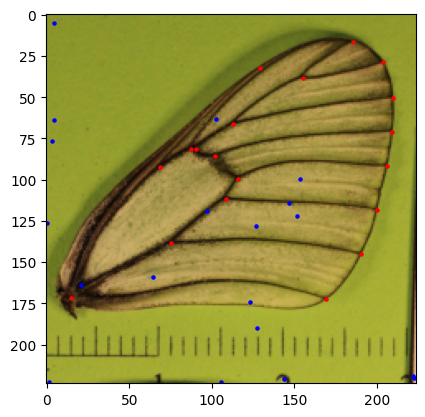

In [52]:
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
images = unorm(images).squeeze()
images = images.permute(1, 2, 0).numpy()

plt.imshow(images)
plt.scatter(landmark[:,0],landmark[:,1], color = 'red' , s = 5)
plt.scatter(prediction[:,0],prediction[:,1], color = 'blue' , s = 5)
plt.show()